<div align="center">
    <img src="https://www.universidades.com.ec/logos/original/logo-universidad-politecnica-salesiana.png">
    <h1 style="text-align: center;"><span style="text-align: center; color: #0000ff;"><strong>PROYECTO INTEGRADOR FINAL</strong></span></h1>
    <p style="text-align: center;"><span style="text-align: center;"><strong>ESTUDIANTES: ANGEL RUIZ - ESTEBAN ROSERO</strong></span></p>
</div>

# Deteccion de noticias falsas
La Deteccion de noticias en el mundo moderno han cambiado la forma en que las noticias son generadas, en las redes sociales 
se sumergen en campañas de desinformacion no legitimas en las cuales, publican cierta infromacion con veracidad dudosa que a sus lectores logra provocar incertidumbre sobre la lectura de dicha informacion, al recalar varia de esta informacion en las redes sociales y provocar varios conflictos sociales, se a comenzado a trabajar en varios detectores de noticias falsas para que asi la gente pueda notificarse solo de informacion original.


## Importamos las librerias
Procedemos a importar las librerias que vamos a ocupar para el analisis de noticias falsas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Datos
Recogemos la informacion de las noticias de politica sobre los EEUU tanto originales en un dataset y en el otro son noticias falsas con relacion a las noticias originales, esta informacion la sacamos del siguiente link
<a href="https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset">Abrir Kaggle</a>

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Limpiamos la Data y Preparacion
Procedemos a preparar la data en esta seccion nosotros debemos limpiar la informacion relevante del dataset, y despues procedmos tambien a eliminar las columnas innecesarias, como tambien limpiar el texto, que sea solo en minusculas y eliminar los signos dentro del texto.

In [5]:
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
data.head()

,title,text,subject,date,target
0,‘DEAD BROKE’ HILLARY’S HAMPTONS VACATION WITH ...,Hillary s been campaigning so hard that she ne...,politics,"Aug 16, 2015",fake
1,New fires ravage Rohingya villages in northwes...,YANGON (Reuters) - Up to eight villages were b...,worldnews,"September 9, 2017",true
2,TOP NAVY COMMANDER RELEASED After Reportedly R...,"Seven years ago, this story would ve seemed li...",left-news,"Feb 1, 2016",fake
3,SHOCKING! EVIDENCE SHOWS WHY OBAMA IS HEART OF...,There will be no peace in America until white...,left-news,"Sep 8, 2015",fake
4,AWESOME PRO-GUN AD Removed From Airport After ...,The rainbows and unicorn crowd decided they ju...,politics,"Jul 9, 2016",fake


In [9]:
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,‘DEAD BROKE’ HILLARY’S HAMPTONS VACATION WITH ...,Hillary s been campaigning so hard that she ne...,politics,fake
1,New fires ravage Rohingya villages in northwes...,YANGON (Reuters) - Up to eight villages were b...,worldnews,true
2,TOP NAVY COMMANDER RELEASED After Reportedly R...,"Seven years ago, this story would ve seemed li...",left-news,fake
3,SHOCKING! EVIDENCE SHOWS WHY OBAMA IS HEART OF...,There will be no peace in America until white...,left-news,fake
4,AWESOME PRO-GUN AD Removed From Airport After ...,The rainbows and unicorn crowd decided they ju...,politics,fake


In [10]:
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Hillary s been campaigning so hard that she ne...,politics,fake
1,YANGON (Reuters) - Up to eight villages were b...,worldnews,true
2,"Seven years ago, this story would ve seemed li...",left-news,fake
3,There will be no peace in America until white...,left-news,fake
4,The rainbows and unicorn crowd decided they ju...,politics,fake


In [11]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,hillary s been campaigning so hard that she ne...,politics,fake
1,yangon (reuters) - up to eight villages were b...,worldnews,true
2,"seven years ago, this story would ve seemed li...",left-news,fake
3,there will be no peace in america until white...,left-news,fake
4,the rainbows and unicorn crowd decided they ju...,politics,fake


In [12]:

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

### Procedemos a remover las stopwords en ingles
Para el analisis de las noticias falsas procedemos a borrar la informacion que nos es inncesaria como lo son las stopwords, estas son las denominadas palabras vacias, que son los articulos, los pronombres, preposiciones, etc.

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
data.head()

,text,subject,target
0,hillary campaigning hard needs hamptons vacati...,politics,fake
1,yangon reuters eight villages burned friday pa...,worldnews,true
2,seven years ago story would seemed like someth...,left-news,fake
3,peace america whites begin hate whiteness reve...,left-news,fake
4,rainbows unicorn crowd decided complain gun ma...,politics,fake


## Contador de Palabras mas frecuentes
Procedemos a generar el tokenizer, el contador de palabras mas frecuentes dentro del texto

In [15]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

## Modelo

In [16]:

from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparamos la data para el entrenamiento y la prueba
Para las pruebas vamos a realizar la separacion 80% y 20%, en la cual el 80% se va al entrenamiento y el 20% a las pruebas.

In [17]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Modelos
Para la creacion de los modelos nosotros decidimos compararlo enre el modelo de regresion que es uno de los mas basicos, con el clasificador random forest, que nos da un mejor resultado

### Modelo de regresion

In [18]:

from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])


model = pipe.fit(X_train, y_train)


prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.46%


Confusion matrix, without normalization


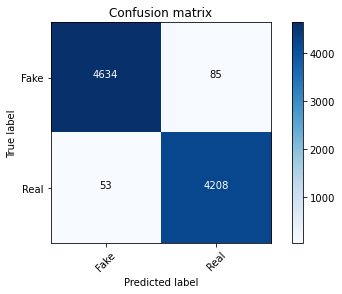

In [19]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Clasificador

In [20]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.85%


Confusion matrix, without normalization


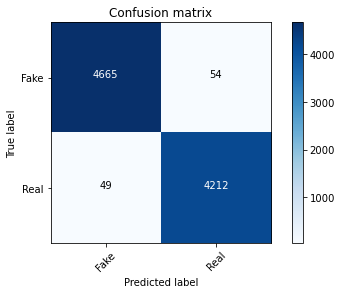

In [21]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## Pruebas
Para las pruebas procedemos a realizar con dos noticias, una de ellas es una noticia original y la otra es falsa, despues procederemos a realizar el analisis de sentimientos.

In [22]:
data['text']

0        hillary campaigning hard needs hamptons vacati...
1        yangon reuters eight villages burned friday pa...
2        seven years ago story would seemed like someth...
3        peace america whites begin hate whiteness reve...
4        rainbows unicorn crowd decided complain gun ma...
                               ...                        
44893    one time ann coulter thought donald trump grea...
44894    following mass exodus hispanic surrogates trum...
44895    msnbc casey hunt interviewing warhawk rino sen...
44896    donald trump fell face repeatedly sunday night...
44897    rome reuters united nations preparing deploy 1...
Name: text, Length: 44898, dtype: object

In [23]:
print(X_test.get(1))

yangon reuters eight villages burned friday part northwest myanmar large numbers muslim rohingya sheltering wave violence engulfing area witness three sources briefed matter told reuters fires blazing ethnically mixed rathedaung township populations rohingya muslims rakhine buddhists live side side today around 4 pm saw smoke coming villages burning saw chin village staying said villager area contacted reuters phone unclear set fire villages independent journalists allowed area myanmar says security forces carrying clearance operations defend extremist terrorists rights monitors fleeing rohingya say army rakhine vigilantes unleashed campaign arson aimed driving muslim population burning villages likely fuel exodus rohingya neighboring bangladesh nearly 270000 fled less two weeks creating humanitarian crisis myanmar leader aung san suu kyi said thursday government best protect everyone drawn criticism around world failing speak violence muslim minority including calls revoke 1991 nobel 

In [24]:
prediction[1]

'true'

In [25]:
print(X_test.get(7))

welcome big leagues kiddonald trump supreme court justice made senate confirmation republicans changed rules could complete robbery seat president obama pick merrick garlandneil gorsuch sits high court first day monday course like trump embarrassed getgogorsuch first case involved census bureau worker dismissed filed lawsuit itthe former government employee lawyers want entire case allowed move forward instead part heard federal appeals courts rather keep mouth shut learn gorsuch apparently decided try prove belonged thereand waste time gorsuch argumentative spent lots time wording words looks like gorsuch going asshole judge going base every decision makes exact wording interpretation words going nitpick decide cases technicalitiesbut gorsuch decided go even changing decorum court channeling trump gorsuch literally accused attorney chris landau lying open courtaccording bloomberglandau asked court let man entire suit go forward federal district court rather waiting part case addressed

In [26]:
prediction[7]

'true'

# Analisis de sentimiento
Con el analisis de sentimiento podemos observar el patron de comportamiento de las noticias verdaderas y falsa, ademas si somos una empresa que utilice la data de noticias podremos obtener mejores conclusiones de la misma.

<h2><span style="color: #000000;"> Importaci&oacute;n de librerias</span></h2>

In [27]:
from collections import Counter
import numpy as np
import time
import sys
import numpy as np
from collections import Counter

<h2><span style="color: #000000;"> Importaci&oacute;n de datos</span></h2>
<p>Se importan los datasets que se ultizaran para obtener todos los datos necesarios</p>

In [29]:
def review_and_label(i):
    print(labels[i] + "\t:\t" + reviews[i][:80] + "...")

g = open('./data/reviews.txt','r')
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open('./data/labels.txt','r')
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

<h2><span style="color: #000000;">Variables</span></h2>
<p>Count para almacenar conteos positivos, negativos y totales</p>

In [30]:
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

counter = 0
for review in reviews:
    words = review.split(' ')
    if labels[counter] == 'POSITIVE':
        positive_counts.update(words)
    else:
        negative_counts.update(words)
    total_counts.update(words)
    counter += 1

<h2><span style="color: #000000;">Muestra</span></h2>
<p>Los 20 primeros recuentos de las palabras más comunes en las revisiones positivas</p>

In [31]:
positive_counts.most_common()[:20]

[('', 550468),
 ('the', 173324),
 ('.', 159654),
 ('and', 89722),
 ('a', 83688),
 ('of', 76855),
 ('to', 66746),
 ('is', 57245),
 ('in', 50215),
 ('br', 49235),
 ('it', 48025),
 ('i', 40743),
 ('that', 35630),
 ('this', 35080),
 ('s', 33815),
 ('as', 26308),
 ('with', 23247),
 ('for', 22416),
 ('was', 21917),
 ('film', 20937)]

<h2><span style="color: #000000;">Muestra</span></h2>
<p>Los 20 primeros recuentos de las palabras más comunes en las revisiones negativas</p>

In [32]:
negative_counts.most_common()[:20]

[('', 561462),
 ('.', 167538),
 ('the', 163389),
 ('a', 79321),
 ('and', 74385),
 ('of', 69009),
 ('to', 68974),
 ('br', 52637),
 ('is', 50083),
 ('it', 48327),
 ('i', 46880),
 ('in', 43753),
 ('this', 40920),
 ('that', 37615),
 ('s', 31546),
 ('was', 26291),
 ('movie', 24965),
 ('for', 21927),
 ('but', 21781),
 ('with', 20878)]

<h2><span style="color: #000000;">Analisis</span></h2>
<p>Las proporciones nos dicen qué palabras se usan con más frecuencia en las revisiones positivas o positivas, pero los valores específicos que hemos calculado son un poco difíciles de trabajar. Una palabra muy positiva como "amazing" tiene un valor superior a 4, mientras que una palabra muy negativa como "terrible" tiene un valor de alrededor de 0.18. Para solucionar estos problemas, convertiremos todas nuestras proporciones en nuevos valores utilizando logaritmos.</p>

In [33]:
pos_neg_ratios = Counter()
for word in total_counts.elements():
    if total_counts[word] >= 100:
        pos_neg_ratios[word] = positive_counts[word] / float(negative_counts[word] + 1)
        
print("Pos-to-neg ratio para 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio para 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio para 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio para 'the' = 1.0607993145235326
Pos-to-neg ratio para 'amazing' = 4.022813688212928
Pos-to-neg ratio para 'terrible' = 0.17744252873563218


<h2><span style="color: #000000;">Analisis</span></h2>
<p>Examinamos las nuevas proporciones que hemos calculado para las mismas palabras de antes:</p>

In [34]:
for word in pos_neg_ratios:
    ratio = pos_neg_ratios[word]
    pos_neg_ratios[word] = np.log(ratio)

print("Pos-to-neg ratio para 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio para 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio para 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio para 'the' = 0.05902269426102881
Pos-to-neg ratio para 'amazing' = 1.3919815802404802
Pos-to-neg ratio para 'terrible' = -1.7291085042663878


In [35]:
pos_neg_ratios.most_common()[:20]

[('edie', 4.6913478822291435),
 ('paulie', 4.07753744390572),
 ('felix', 3.152736022363656),
 ('polanski', 2.8233610476132043),
 ('matthau', 2.80672172860924),
 ('victoria', 2.681021528714291),
 ('mildred', 2.6026896854443837),
 ('gandhi', 2.538973871058276),
 ('flawless', 2.451005098112319),
 ('superbly', 2.26002547857525),
 ('perfection', 2.159484249353372),
 ('astaire', 2.1400661634962708),
 ('captures', 2.038619547159581),
 ('voight', 2.030170492673053),
 ('wonderfully', 2.0218960560332353),
 ('powell', 1.978345424808467),
 ('brosnan', 1.9547990964725592),
 ('lily', 1.9203768470501485),
 ('bakshi', 1.9029851043382795),
 ('lincoln', 1.9014583864844796)]

<h2><span style="color: #000000;">Analisis</span></h2>
<p>Analizamos palabras que se ven con mayor frecuencia en una revisión con una etiqueta "NEGATIVA"</p>

In [36]:
list(reversed(pos_neg_ratios.most_common()))[0:20]

[('boll', -4.969813299576001),
 ('uwe', -4.624972813284271),
 ('seagal', -3.644143560272545),
 ('unwatchable', -3.258096538021482),
 ('stinker', -3.2088254890146994),
 ('mst', -2.9502698994772336),
 ('incoherent', -2.9368917735310576),
 ('unfunny', -2.6922395950755678),
 ('waste', -2.6193845640165536),
 ('blah', -2.5704288232261625),
 ('horrid', -2.4849066497880004),
 ('pointless', -2.4553061800117097),
 ('atrocious', -2.4259083090260445),
 ('redeeming', -2.3682390632154826),
 ('prom', -2.3608540011180215),
 ('drivel', -2.3470368555648795),
 ('lousy', -2.307572634505085),
 ('worst', -2.286987896180378),
 ('laughable', -2.264363880173848),
 ('awful', -2.227194247027435)]

<h2><span style="color: #000000;">Creacion de datos de entrada/salida</span></h2>
<p>Creamos un conjunto denominado vocab que contenga cada palabra en el vocabulario.</p>

In [37]:
vocab = set(total_counts)
vocab_size = len(vocab)
print(vocab_size)
layer_0 = np.zeros((1, vocab_size))
layer_0.shape

74074


(1, 74074)

<h2><span style="color: #000000;">Creacion de un diccionario</span></h2>
<p>Creamos un diccionario de palabras en el vocabulario asignado a las posiciones de índice</p>

In [38]:
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

c = 0
for w in word2index:
    if c < 20:
        print(w, end="")
        print(' : ', end="")
        print(word2index[w])
    c = c + 1

 : 0
pokey : 1
christianty : 2
brattiness : 3
rapacious : 4
excuses : 5
platitudinous : 6
truffle : 7
dethman : 8
thrill : 9
oblige : 10
marischka : 11
cusp : 12
quatermain : 13
clment : 14
grayscale : 15
investigator : 16
borrows : 17
earthlings : 18
begrudgingly : 19


<h2><span style="color: #000000;">Funciones</span></h2>
<p>Debe contar cuántas veces se usa cada palabra en la revisión dada, y luego almacenar esos conteos en los índices apropiados dentro de layer_0.</p>

In [39]:
def update_input_layer(review):
    global layer_0
    layer_0 *= 0
    for word in review.split(" "):
        layer_0[0][word2index[word]] += 1

update_input_layer(reviews[0])
layer_0

def get_target_for_label(label):
    if (label=="POSITIVE"):
        return 1
    else:
        return 0

<h2><span style="color: #000000;">Red Neuronal</span></h2>
Se utiliza una clase llamada SentimentNetwork. 
Los pasos a seguir son los siguientes:

* Crear una red neuronal básica como las redes con una capa de entrada, una capa oculta y una capa de salida.
* No agregamos una non-linearity en la capa oculta. Es decir, no usa una función de activación cuando calcule las salidas de la capa oculta.
* Implementamos la función pre_process_data para crear el vocabulario de nuestras funciones de generación de datos de capacitación
* Asegurar que se entrene sobre todo el corpus

In [40]:
class SentimentNetwork:

    def __init__(self, reviews,labels,min_count = 10,polarity_cutoff = 0.1,hidden_nodes = 10, learning_rate = 0.1):
        """Creamos SentimenNetwork con la configuración dada
         Args:
             revisiones (lista) - Lista de revisiones usadas para entrenamiento
             labels (list) - Lista de etiquetas POSITIVAS / NEGATIVAS asociadas con las revisiones dadas
             min_count (int) - Las palabras solo deben agregarse al vocabulario
                              si ocurren más que esto muchas veces
             polarity_cutoff (float) - El valor absoluto de la palabra positiva a negativa
                                      la proporción debe ser al menos tan grande como para ser considerada.
             hidden_nodes (int) - Número de nodos para crear en la capa oculta
             learning_rate (float) - Tasa de aprendizaje para usar durante el entrenamiento
        
        """
        # Asignar una semilla a nuestro generador de números aleatorios para asegurarnos de obtener resultados reproducibles durante el desarrollo
        np.random.seed(1)

        # procesar las revisiones y sus etiquetas asociadas para que todo está listo para el entrenamiento
        self.pre_process_data(reviews, labels, polarity_cutoff, min_count)
        
        # Construye la red para tener la cantidad de nodos ocultos y la velocidad de aprendizaje que se pasaron a este inicializador. Haga la misma cantidad de nodos de entrada como hay palabras de vocabulario y crea un solo nodo de salida.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels, polarity_cutoff, min_count):
        
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()

        for i in range(len(reviews)):
            if(labels[i] == 'POSITIVE'):
                for word in reviews[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1

        pos_neg_ratios = Counter()

        for term,cnt in list(total_counts.most_common()):
            if(cnt >= 50):
                pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
                pos_neg_ratios[term] = pos_neg_ratio

        for word,ratio in pos_neg_ratios.most_common():
            if(ratio > 1):
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))

        # poblar review_vocab con todas las palabras en las revisiones dadas
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                if(total_counts[word] > min_count):
                    if(word in pos_neg_ratios.keys()):
                        if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)

        # Convertir el conjunto de vocabulario en una lista para que podamos acceder a las palabras a través de índices
        self.review_vocab = list(review_vocab)
        
        # poblar etiqueta_vocab con todas las palabras en las etiquetas dadas.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convertir el conjunto de vocabulario de la etiqueta en una lista para que podamos acceder a las etiquetas a través de índices
        self.label_vocab = list(label_vocab)
        
        # Almacenar los tamaños de los vocabularios de revisión y etiqueta.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Crear un diccionario de palabras en el vocabulario asignado a las posiciones de índice
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Crear un diccionario de etiquetas mapeadas a posiciones de índice
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i

    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Establecer el número de nodos en las capas de entrada, ocultas y de salida.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Almacenar la tasa de aprendizaje
        self.learning_rate = learning_rate

        # Inicializar los pesos Estos son los pesos entre la capa de entrada y la capa oculta.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))

        # Estos son los pesos entre la capa oculta y la capa de salida.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        # La capa de entrada, una matriz bidimensional con forma 1 x hidden_nodes
        self.layer_1 = np.zeros((1,hidden_nodes))
    
    def get_target_for_label(self,label):
        if(label == 'POSITIVE'):
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)
    
    def train(self, training_reviews_raw, training_labels):

        ## Preprocesamiento de las evaluaciones de capacitación para que podamos tratar directamente con los índices de entradas distintas de cero
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))

        # asegúrate de que tenemos un número coincidente de reseñas y etiquetas
        assert(len(training_reviews) == len(training_labels))
        
        # Realizar un seguimiento de las predicciones correctas para mostrar la precisión durante el entrenamiento
        correct_so_far = 0

        # Recuerda cuando comenzamos a imprimir las estadísticas de tiempo
        start = time.time()
        
        # recorrer todas las evaluaciones dadas y ejecutar un pase hacia adelante y hacia atrás, actualización de pesos para cada artículo
        for i in range(len(training_reviews)):
            
            # Obtener la siguiente revisión y su etiqueta correcta
            review = training_reviews[i]
            label = training_labels[i]
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            # Output layer
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))            
            
            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # El error de la capa de salida es la diferencia entre el objetivo deseado y la salida real.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errores propagados a la capa oculta
            layer_1_delta = layer_1_error # gradientes de capas ocultas, sin falta de linealidad, es el mismo que el error

            # Actualiza los pesos
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # actualizar pesos ocultos a salida con paso de descenso de degradado
            
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate # actualizar pesos de entrada a ocultos con paso de descenso de gradiente

            # Manten un registro de las predicciones correctas.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # Para depuración, imprime nuestra precisión y velocidad de predicción a lo largo del proceso de capacitación.
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Intenta predecir las etiquetas para las evaluaciones de prueba dadas,
         y usa test_labels para calcular la precisión de esas predicciones.
        """
        
        # realizar un seguimiento de la cantidad de predicciones correctas que hacemos
        correct = 0

        # vamos a cronometrar cuántas predicciones por segundo hacemos
        start = time.time()

        # Pasa por cada una de las revisiones dadas y ejecuta la llamada para predecir su etiqueta.
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # Para depuración, imprima nuestra precisión y velocidad de predicción durante todo el proceso de predicción.

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Devuelve una predicción POSITIVA o NEGATIVA para la revisión dada.
        """
        ## Hidden layer
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        ## Output layer
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
         
        # Devuelve POSITIVO para valores superiores a mayor que o igual a 0.5 en la capa de salida; devuelve NEGATIVO para otros valores
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

<h2><span style="color: #000000;">Entrenamiento</span></h2>

In [41]:
mlp_full = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=0,polarity_cutoff=0,learning_rate=0.01)
mlp_full.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):2021. #Correct:1962 #Trained:2501 Training Accuracy:78.4%
Progress:20.8% Speed(reviews/sec):1996. #Correct:4002 #Trained:5001 Training Accuracy:80.0%
Progress:31.2% Speed(reviews/sec):2025. #Correct:6120 #Trained:7501 Training Accuracy:81.5%
Progress:41.6% Speed(reviews/sec):2041. #Correct:8271 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):2048. #Correct:10431 #Trained:12501 Training Accuracy:83.4%
Progress:62.5% Speed(reviews/sec):2042. #Correct:12565 #Trained:15001 Training Accuracy:83.7%
Progress:72.9% Speed(reviews/sec):2034. #Correct:14670 #Trained:17501 Training Accuracy:83.8%
Progress:83.3% Speed(reviews/sec):2022. #Correct:16833 #Trained:20001 Training Accuracy:84.1%
Progress:93.7% Speed(reviews/sec):2020. #Correct:19015 #Trained:22501 Training Accuracy:84.5%
Progress:99.9% Speed(reviews/sec):2021. #Correct:20335 #Trained:24000 Training

<h2><span style="color: #000000;">Pruebas</span></h2>
Con las noticias que comprobamos anteriormente analizamos el sentimiento de las mismas.

In [42]:
mlp_full.run("front page news every major media outletrussian intelligence targeted hillary clinton became secretary state 2009 fbi documents shownew fbi information corruption clintonapproved uranium deal russia raises questions clinton actions fbi broke deepcover russian spy ring 2010for decade fbi ran operation called ghost stories monitor rip apart deepcover russian agent network ghost stories tracked ring russian spies lived boston washington dc false identities one fbi elaborate successful counterintelligence operations historyafter fbi arrested 10 spies june 2010 secretary state clinton worked feverishly return russian agents moscow hastily arranged lopsided deal putinit happened uranium deal play arrangement provide moscow state rosatom nuclear agency 20 percent american uranium capacity 145000000 pour clinton family foundation projectsfor clintons fbi biggest counterintelligence bust history come worse timethe day fbi arrested russian agents june 28 2010 day secretary state husband bill clinton give speech moscow kremlinconnected investment bank renaissance capital paid former president 500000 hourlong appearancean unnamed hillary clinton spokesman told abc news reason think secretary target spy ring lieunder code name operation ghost stories fbi working ring decade targets burrowed along acela corridor boston new york washington dc lived normal daily lives americans attend universities run businesses marry conceive raise children infiltrate society subvert government institutions one svr agents stolen identity sixweekold canadian baby died 1963 prompted ghost stories code name ring inspired fx network television series americans secretary state hillary clinton would primary target circumstance much known quantity predictable vain ruthless insatiable desire cash enrich family friends political machine blindly ambitious become president world superpower swearing come back losing 2008 barack obama 21st century kgb perfect markread daily caller")

'POSITIVE'

In [43]:
mlp_full.run("berlin reuters european union chief brexit negotiator michel barnier said wednesday bloc united dealing britain withdrawal bloc warned failure reach agreement would bad deal would bad deal barnier said switching french english speech germany bda employers association third speech german audience brexit day far barnier also said hoped made progress principles britain divorce eu next week london knew could one foot single market one foot")

'NEGATIVE'